In [5]:
import numpy as np
import pandas as pd

import obspy


import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from time import localtime, strftime

%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, BatchNormalization, add
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from numpy.fft import fft, ifft
from tensorflow.keras.utils import to_categorical
from scipy.special import softmax
from scipy.signal import lfilter, butter, decimate

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from math import radians, degrees, cos, sin


model_folder = 'models/'
log_folder = 'logs/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):

    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def base_model(win_len, nb_chan, nb_filters, filter_len, dilations, nb_stacks,
               padding='same', drop=0.05):

    input_layer = Input(shape=(win_len, nb_chan))
    
    x = input_layer
    x = Convolution1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)
    
    output_layer = Convolution1D(nb_chan, 1, padding=padding)(x)
    model = Model(input_layer, output_layer)

    return model

In [78]:
dat = np.load('data/data.npy').astype('float32')


# Model Parameters
pdict = {}
pdict['f']     = 10
pdict['k']     = 15
pdict['d']     = [2, 4, 8, 16, 32]
pdict['s']     = 1

# Dataset Parameters
pdict['flo']   = .3
pdict['fhi']   = 5
pdict['wlen']  = 30
pdict['glen']  = 1
pdict['fsorig'] = 40
pdict['fs']    = 100


# Training Parameters
pdict['bs']    = 128
pdict['lr']    = .0005
pdict['pat']   = 3
pdict['time']  = strftime("%y-%m-%d-%H-%M-%S", localtime())


In [79]:
def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data) 


In [80]:
def upsample(x, fs_old, fs_new):
    win_len = len(x)/fs_old
    t_old = np.linspace(0, int(win_len-1/fs_old), int(win_len*fs_old))
    t_new = np.linspace(0, int(win_len-1/fs_new), int(win_len*fs_new))
    x = np.interp(t_new, t_old, x)
    return x

In [82]:
def gen(dat, pdict):
    ''' 
    Build a batch of waveforms with gaps
    data:    numpy array with raw data
    bs:      batch size to be generated
    win_len: window length of each example in seconds
    gap_len: gap length in seconds
    fs:      sample rate of signal in hertz
    '''

    # Load in the parameter variables
    bs = pdict['bs']
    fs = pdict['fs']
    flo = pdict['flo']
    fhi = pdict['fhi']
    fsorig = pdict['fsorig']
    gap_len = pdict['glen']
    win_len = pdict['wlen']
    
    # filter and resample the waveforms
    dat = butter_bandpass_filter(dat, flo, fhi, fs=fsorig)
    dat_resamp = []
    for i in range(len(dat)):
        dat_resamp.append(upsample(dat[i], fsorig, fs))
    dat = np.vstack(dat_resamp)
    tot_len = dat.shape[1]
    dat = np.expand_dims(dat, 2)
    
    # Normalize the data
#     dat = dat - np.expand_dims(np.mean(dat,axis=1),1)
#     dat = dat / np.expand_dims(np.max(dat,axis=1),1)
    
    while 1:
        
        # Randomly select a batch of waveforms
        my_indicies = np.random.randint(len(dat), size=bs)

        #Randomly select a window within the waveforms
        my_win_st = np.random.randint(tot_len - win_len * fs)
        my_win_en = my_win_st + win_len * fs
        
        # Build y: a batch of windowed waveforms
        my_y = dat[my_indicies, my_win_st:my_win_en]

        # Build X: a batch of windowed waveforms with gaps added
        my_x = my_y.copy()
        my_gap_st = int((win_len - gap_len) * fs / 2)
        my_gap_en = my_gap_st + gap_len * fs
        my_x[:, my_gap_st:my_gap_en] = 0

        yield my_x, my_y

In [83]:
trn_gen = gen(dat[:10000], pdict)
val_gen = gen(dat[10000:], pdict)

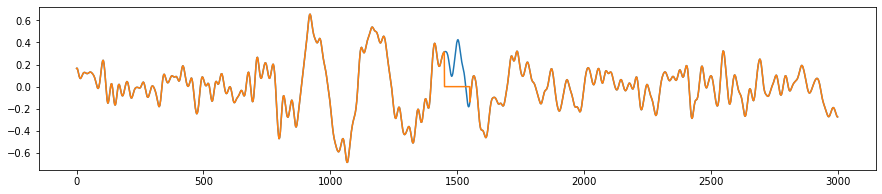

In [85]:
X, Y = next(trn_gen)
            
fig, ax = plt.subplots(1,1, figsize=(15,3))
ax.plot(Y[0,:,0])
ax.plot(X[0,:,0])


In [86]:
def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)
           
                        
def name2param(name):
    name = name[:-3]
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

In [90]:
def load_custom_model(pdict, model_folder='models'):
    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f"|time:{pdict['iniW']}" in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        my_loss = 'mse'
        model = load_model(model_file, custom_objects={'mse_loss': my_loss})
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)
        
        print('building new model:\n', model_file)
        model = base_model(win_len=None,
                           nb_chan=1,
                           nb_filters=pdict['f'],
                           filter_len=pdict['k'],
                           dilations=pdict['d'],
                           nb_stacks=pdict['s'])
    return model, model_name


def compile_custom_model(model, pdict):
    o = Adam(lr=pdict['lr'], clipnorm=1.)
    my_loss = 'mse'                
    model.compile(loss=my_loss, optimizer=o, metrics=['mae'])

    return model, param2name(pdict)


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]



In [91]:
t_step = 500
v_step = 100

In [92]:
# Build the Model
print('loading model...', end=' ', flush=True)
model, model_name = load_custom_model(pdict)

pdict = name2param(model_name)


model, _ = compile_custom_model(model, pdict)
print('complete')
print(model.summary())

model, model_name = compile_custom_model(model, pdict)
print(model_name)
model_id = pdict['time']

loading model... building new model:
 models/f:10|k:15|d:2x4x8x16x32|s:1|flo:0.3|fhi:5|wlen:30|glen:1|fsorig:40|fs:100|bs:128|lr:0.0005|pat:3|time:22-02-12-09-37
complete
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_65 (Conv1D)              (None, None, 10)     20          input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, None, 10)     1510        conv1d_65[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activ

In [93]:
history = model.fit(trn_gen, steps_per_epoch=t_step, epochs=5000,
                              validation_data=val_gen, validation_steps=v_step,
                              callbacks=get_callbacks(model_name, model_folder, log_folder))

/home/dickey/anaconda3/envs/aiml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/dickey/anaconda3/envs/aiml/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5000
500/500 [==============================] - 482s 960ms/step - loss: 0.0021 - mae: 0.0219 - val_loss: 7.0799e-04 - val_mae: 0.0095
Epoch 2/5000
500/500 [==============================] - 467s 935ms/step - loss: 7.9144e-04 - mae: 0.0120 - val_loss: 6.0380e-04 - val_mae: 0.0077
Epoch 3/5000
500/500 [==============================] - 466s 933ms/step - loss: 6.7312e-04 - mae: 0.0099 - val_loss: 6.7685e-04 - val_mae: 0.0078
Epoch 4/5000
500/500 [==============================] - 467s 934ms/step - loss: 6.3774e-04 - mae: 0.0090 - val_loss: 5.5093e-04 - val_mae: 0.0064
Epoch 5/5000
500/500 [==============================] - 466s 933ms/step - loss: 5.5746e-04 - mae: 0.0078 - val_loss: 4.8386e-04 - val_mae: 0.0054
Epoch 6/5000
500/500 [==============================] - 466s 932ms/step - loss: 5.4891e-04 - mae: 0.0071 - val_loss: 4.9682e-04 - val_mae: 0.0050
Epoch 7/5000
500/500 [==============================] - 466s 933ms/step - loss: 5.0460e-04 - mae: 0.0065 - val_loss: 4.9330e-04 

In [95]:
X, Y = next(val_gen)
Z = model.predict(X)

In [125]:
X[idx, st:en, 0].shape

(2999,)

In [136]:
z - y

array([ -2.64339105e-02,  -2.46485805e-02,  -1.38399552e-02,
        -1.16573375e-02,   8.29968631e-03,   8.03848677e-03,
         9.77224908e-03,   8.61272346e-03,  -8.21262469e-03,
        -8.34726759e-03,  -1.24165621e-02,  -1.19766055e-02,
        -6.07691482e-03,  -8.30087038e-03,  -1.14649583e-02,
        -1.20177741e-02,  -8.35750090e-03,  -7.95298985e-03,
        -4.32128950e-03,  -6.60170646e-03,  -6.04650743e-03,
        -6.72379416e-03,  -8.38689155e-03,  -8.68577928e-03,
        -6.64106879e-03,  -6.98698140e-03,  -5.70526063e-03,
        -4.91747622e-03,  -3.03188794e-03,  -2.68824502e-03,
        -1.57784795e-03,  -1.55256572e-03,  -4.17326657e-03,
        -2.14551546e-03,  -3.92363435e-03,  -2.32655082e-03,
        -4.33499761e-03,  -4.30941246e-03,  -2.87647456e-03,
        -5.22990342e-03,   5.56769753e-04,   1.34609637e-03,
         1.41375605e-03,   1.16013078e-03,  -1.72639711e-03,
        -2.26919586e-03,  -2.25260257e-03,  -2.26817700e-04,
        -3.86148916e-04,

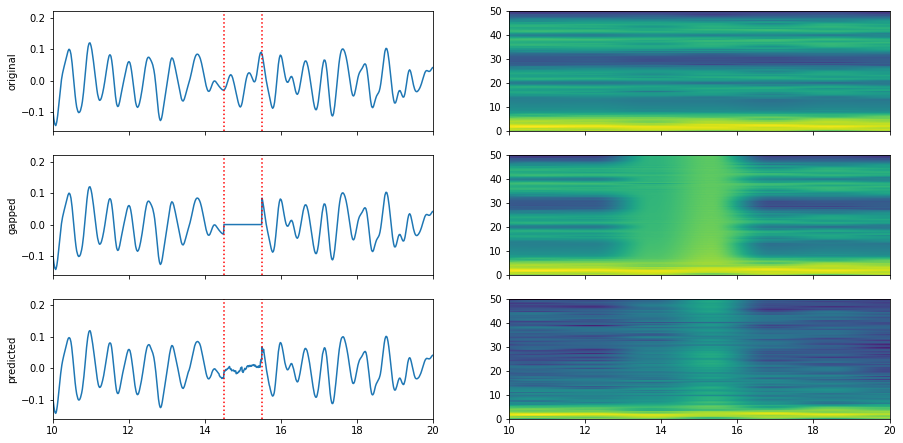

In [151]:
idx = np.random.randint(len(X))
st = 10
en = 20

fig, ax = plt.subplots(3,2,figsize=(15,7.5), sharex=True, sharey=False)

gap_st = int((pdict['wlen'] - pdict['glen']) * pdict['fs'] / 2) / pdict['fs']
gap_en = gap_st + pdict['glen']
t = np.linspace(0, pdict['wlen'], X.shape[1])

x = X[idx, :, 0]
y = Y[idx, :, 0]
z = Z[idx, :, 0]

ax[0,0].plot(t, y)
ax[1,0].plot(t, x)
ax[2,0].plot(t, z)

ax[0,1].specgram(y, NFFT=256, Fs=pdict['fs'], noverlap=100)
ax[1,1].specgram(x, NFFT=256, Fs=pdict['fs'], noverlap=100)
ax[2,1].specgram(z, NFFT=256, Fs=pdict['fs'], noverlap=100)

ax[0,0].set_ylabel('original')
ax[1,0].set_ylabel('gapped')
ax[2,0].set_ylabel('predicted')

for i in range(3):
    ax[i,0].set_xlim((st,en))
    ax[i,0].axvline(gap_st, c='r', ls=':')
    ax[i,0].axvline(gap_en, c='r', ls=':')

plt.savefig('seismogap.jpg')

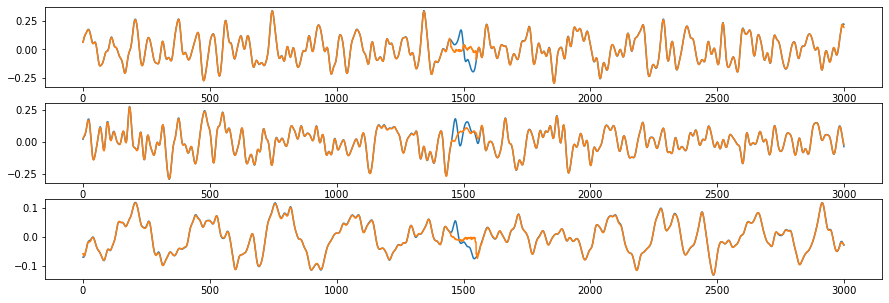

In [152]:
fig, ax = plt.subplots(3,1,figsize=(15,5))

for i in range(3):
    ax[i].plot(Y[i])
    ax[i].plot(Z[i])

plt.savefig('seismogap.jpg')